# DES Hub Netbacks - Percentage of Terminals "In the Money"
Determining how many terminals are considered "in the money", as a percentage of the all the major LNG European terminals on Spark Access. Useful as a signal for European LNG flows.

### Have any questions?

If you have any questions regarding our API, or need help accessing specific datasets, please contact us at:

__data@sparkcommodities.com__


## 1. Importing Data

Here we define the functions that allow us to retrieve the valid credentials to access the Spark API.

This section can remain unchanged for most Spark API users.

In [31]:
# import libraries for callin the API
import json
import os
import sys
import pandas as pd
from base64 import b64encode
from urllib.parse import urljoin
from pprint import pprint
import requests
from io import StringIO
import time
import numpy as np
import datetime

try:
    from urllib import request, parse
    from urllib.error import HTTPError
except ImportError:
    raise RuntimeError("Python 3 required")

In [32]:
# defining query functions 
API_BASE_URL = "https://api.sparkcommodities.com"


def retrieve_credentials(file_path=None):
    """
    Find credentials either by reading the client_credentials file or reading
    environment variables
    """
    if file_path is None:
        client_id = os.getenv("SPARK_CLIENT_ID")
        client_secret = os.getenv("SPARK_CLIENT_SECRET")
        if not client_id or not client_secret:
            raise RuntimeError(
                "SPARK_CLIENT_ID and SPARK_CLIENT_SECRET environment vars required"
            )
    else:
        # Parse the file
        if not os.path.isfile(file_path):
            raise RuntimeError("The file {} doesn't exist".format(file_path))

        with open(file_path) as fp:
            lines = [l.replace("\n", "") for l in fp.readlines()]

        if lines[0] in ("clientId,clientSecret", "client_id,client_secret"):
            client_id, client_secret = lines[1].split(",")
        else:
            print("First line read: '{}'".format(lines[0]))
            raise RuntimeError(
                "The specified file {} doesn't look like to be a Spark API client "
                "credentials file".format(file_path)
            )

    print(">>>> Found credentials!")
    print(
        ">>>> Client_id={}****, client_secret={}****".format(
            client_id[:5], client_secret[:5]
        )
    )

    return client_id, client_secret


def do_api_post_query(uri, body, headers):
    """
    OAuth2 authentication requires a POST request with client credentials before accessing the API. 
    This POST request will return an Access Token which will be used for the API GET request.
    """
    url = urljoin(API_BASE_URL, uri)

    data = json.dumps(body).encode("utf-8")

    # HTTP POST request
    req = request.Request(url, data=data, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 201, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content


def do_api_get_query(uri, access_token):
    """
    After receiving an Access Token, we can request information from the API.
    """
    url = urljoin(API_BASE_URL, uri)

    headers = {
        "Authorization": "Bearer {}".format(access_token),
        "accept": "application/json",
    }

    print(f"Fetching {url}")

    # HTTP GET request
    req = request.Request(url, headers=headers)
    try:
        response = request.urlopen(req)
    except HTTPError as e:
        print("HTTP Error: ", e.code)
        print(e.read())
        sys.exit(1)

    resp_content = response.read()

    # The server must return HTTP 201. Raise an error if this is not the case
    assert response.status == 200, resp_content

    # The server returned a JSON response
    content = json.loads(resp_content)

    return content


def get_access_token(client_id, client_secret):
    """
    Get a new access_token. Access tokens are the thing that applications use to make
    API requests. Access tokens must be kept confidential in storage.

    # Procedure:

    Do a POST query with `grantType` and `scopes` in the body. A basic authorization
    HTTP header is required. The "Basic" HTTP authentication scheme is defined in
    RFC 7617, which transmits credentials as `clientId:clientSecret` pairs, encoded
    using base64.
    """

    # Note: for the sake of this example, we choose to use the Python urllib from the
    # standard lib. One should consider using https://requests.readthedocs.io/

    payload = "{}:{}".format(client_id, client_secret).encode()
    headers = {
        "Authorization": b64encode(payload).decode(),
        "Accept": "application/json",
        "Content-Type": "application/json",
    }
    body = {
        "grantType": "clientCredentials",
        "scopes": "read:access,read:prices"
    }

    content = do_api_post_query(uri="/oauth/token/", body=body, headers=headers)

    print(
        ">>>> Successfully fetched an access token {}****, valid {} seconds.".format(
            content["accessToken"][:5], content["expiresIn"]
        )
    )

    return content["accessToken"]

## N.B. Credentials

Here we call the above functions, and input the file path to our credentials.

N.B. You must have downloaded your client credentials CSV file before proceeding. Please refer to the API documentation if you have not dowloaded them already.

The code then prints the available prices that are callable from the API, and their corresponding Python ticker names are displayed as a list at the bottom of the Output.

In [ ]:
# Insert file path to your client credentials here
client_id, client_secret = retrieve_credentials(file_path="/tmp/client_credentials.csv")

# Authenticate:
access_token = get_access_token(client_id, client_secret)

>>>> Found credentials!
>>>> Client_id=01c23****, client_secret=80763****
>>>> Successfully fetched an access token eyJhb****, valid 604799 seconds.


## 2. DES Hub Netbacks

Calling the DES Hub Netbacks data, and sorting into a Historical DataFrame

In [34]:
## Defining the function to import the data

def fetch_deshub_releases(access_token, unit, limit=None, offset=None, terminal=None):
    
    query_params = "?unit={}".format(unit)
    if limit is not None:
        query_params += "&limit={}".format(limit)
    if offset is not None:
        query_params += "&offset={}".format(offset)
    if terminal is not None:
        query_params += "&terminal={}".format(terminal)


    content = do_api_get_query(
        uri="/beta/access/des-hub-netbacks/{}".format(query_params), access_token=access_token
    )

    return content


In [ ]:
# Sorting the JSON into a Pandas DataFrame

def deshub_organise_dataframe(data):
    """
    This function sorts the API content into a dataframe. The columns available are Release Date, Terminal, Month, Vessel Size, $/MMBtu and €/MWh. 
    Essentially, this function parses the Access database using the Month, Terminal and Vessel size columns as reference.
    """
    # create columns
    data_dict = {
        'Release Date':[],
        'Terminal':[],
        'Month Index':[],
        'Delivery Month':[],
        'DES Hub Netback - TTF Basis':[],
        'DES Hub Netback - Outright':[],
        'Total Regas':[],
        'Basic Slot (Berth)':[],
        'Basic Slot (Unload/Stor/Regas)':[],
        'Basic Slot (B/U/S/R)':[],
        'Additional Storage':[],
        'Additional Sendout':[],
        'Gas in Kind': [],
        'Entry Capacity':[],
        'Commodity Charge':[]
    }

    # loop for each Terminal
    for l in data['data']:
        
        # assigning values to each column
        data_dict['Release Date'].append(l["releaseDate"])
        data_dict['Terminal'].append(data['metaData']['terminals'][l['terminalUuid']])
        data_dict['Month Index'].append(l['monthIndex'])
        data_dict['Delivery Month'].append(l['deliveryMonth'])

        data_dict['DES Hub Netback - TTF Basis'].append(float(l['netbackTtfBasis']))
        data_dict['DES Hub Netback - Outright'].append(float(l['netbackOutright']))
        data_dict['Total Regas'].append(float(l['totalRegasificationCost']))
        data_dict['Basic Slot (Berth)'].append(float(l['slotBerth']))
        data_dict['Basic Slot (Unload/Stor/Regas)'].append(float(l['slotUnloadStorageRegas']))
        data_dict['Basic Slot (B/U/S/R)'].append(float(l['slotBerthUnloadStorageRegas']))
        data_dict['Additional Storage'].append(float(l['additionalStorage']))
        data_dict['Additional Sendout'].append(float(l['additionalSendout']))
        data_dict['Gas in Kind'].append(float(l['gasInKind']))
        data_dict['Entry Capacity'].append(float(l['entryCapacity']))
        data_dict['Commodity Charge'].append(float(l['commodityCharge']))
                
    
    # convert into dataframe
    df = pd.DataFrame(data_dict)
    
    df['Delivery Month'] = pd.to_datetime(df['Delivery Month'])
    df['Release Date'] = pd.to_datetime(df['Release Date'])

    # defining "Variable Regas Costs only" - here, we treat slot costs as the only fixed regas cost component
    df['DES Hub Netback - TTF Basis - Var Regas Costs Only'] = df['DES Hub Netback - TTF Basis'] \
                                                                + df['Basic Slot (B/U/S/R)'] \
                                                                + df['Basic Slot (Berth)'] \
                                                                + df['Basic Slot (B/U/S/R)']
    
    return df


### Historical Data Function

Currently, a maximum of 30 historical datasets can be called at one time due to the size of the data file. 

If more data points are required, the below code can be used. It calls 30 historical datasets at a time, but utilises the 'offset' parameter to call datasets further back in the historical database. To call more history, increase the 'n_offset' parameter in the first line of the code. The 'n_offset' parameter describes the number of historical data requests to be executed.

In [36]:
def loop_historical_data(token,n_offset):
    # initalise first set of historical data and initialising dataframe
    historical = fetch_deshub_releases(access_token, unit='usd-per-mmbtu', limit=30)
    hist_df = deshub_organise_dataframe(historical)
    terminal_list = list(historical['metaData']['terminals'].values())

    # Looping through earlier historical data and adding to the historical dataframe
    for i in range(1,n_offset+1):
        historical = fetch_deshub_releases(access_token, unit='usd-per-mmbtu', limit=30, offset=i*30)
        hist_df = pd.concat([hist_df,deshub_organise_dataframe(historical)])

    return hist_df, terminal_list

In [37]:
loops = 15
hdf, full_terms = loop_historical_data(access_token,loops)

Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30
Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30&offset=30
Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30&offset=60
Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30&offset=90
Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30&offset=120
Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30&offset=150
Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30&offset=180
Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30&offset=210
Fetching https://api.sparkcommodities.com/beta/access/des-hub-netbacks/?unit=usd-per-mmbtu&limit=30&offset=240
Fetching https:

# 3. SparkNWE & SparkSWE - Data Import

Calling the SparkNWE & SparkSWE front month prices (in TTF basis format) to compare against the terminal DES Hub netbacks and determine which terminals are "in the money"

In [38]:
# Calling contracts endpoint to import cargo data
def fetch_cargo_releases(access_token, ticker, limit=4, offset=None):

    print(">>>> Get price releases for {}".format(ticker))

    query_params = "?limit={}".format(limit)
    if offset is not None:
        query_params += "&offset={}".format(offset)

    content = do_api_get_query(
        uri="/v1.0/contracts/{}/price-releases/{}".format(ticker, query_params),
        access_token=access_token,
    )

    my_dict = content['data']
    
    return my_dict

# Function to import data and then sort into a DataFrame
def cargo_to_dataframe(access_token, ticker, limit, month):

    # imports front month or forward curve prices, depending on the "month" user input
    if month == 'M+1':
        full_tick = ticker + '-b-f'
        hist_data = fetch_cargo_releases(access_token, full_tick, limit)
    else:
        full_tick = ticker + '-b-fo'
        hist_data = fetch_cargo_releases(access_token, full_tick, limit)
         

    release_dates = []
    period_start = []
    ticker = []
    spark = []

    spark_min = []
    spark_max = []
    cal_month = []

    # iterating through historical data points to fetch relevant data
    for release in hist_data:
            release_date = release["releaseDate"]
            ticker.append(release['contractId'])
            release_dates.append(release_date)

            mi = int(month[-1])-2

            data_point = release['data'][0]['dataPoints'][mi]

            period_start_at = data_point["deliveryPeriod"]["startAt"]
            period_start.append(period_start_at)
            
            spark.append(data_point['derivedPrices']['usdPerMMBtu']['spark'])
            spark_min.append(data_point['derivedPrices']['usdPerMMBtu']['sparkMin'])
            spark_max.append(data_point['derivedPrices']['usdPerMMBtu']['sparkMax'])
            
            cal_month.append(datetime.datetime.strptime(period_start_at, '%Y-%m-%d').strftime('%b-%Y'))
                

    # Converting into DataFrame
    hist_df = pd.DataFrame({
        'Release Date': release_dates,
        'ticker': ticker,
        'Period Start': period_start,
        'Price': spark,
        })
        
    
    hist_df['Price'] = pd.to_numeric(hist_df['Price'])
    hist_df['Release Date'] = pd.to_datetime(hist_df['Release Date'])

    hist_df['Release Date'] = hist_df['Release Date'].dt.tz_localize(None) 

    return hist_df

# 4. Analysis

- Input contract month required
- Subtracting the SparkNWE/SWE prices from the DES Hub Netbacks to determine whether terminals are "in" or "out of the money".
    - This will be labelled as "WTP", or the "Willingness to Pay" metric
- Calculating the percentage of terminals in/out of the money historically
- Plotting this fractional WTP historical evolution over time

### Inputs

In [39]:
# Choose which forward month you'd like to analyse - either front month ("M+1") or any other month up until M+11
month = 'M+1'

# Here we define which terminals we want to use in the analytics. The default is all terminals, but you can choose a subset if preferred (as demonstrated in comment below)
terms = full_terms.copy()
#terms = ['gate', 'dunkerque', 'zeebrugge']

### Data Calling & Analytical Procedures

In [40]:
# Import NWE/SWE LNG prices
sparknwe = cargo_to_dataframe(access_token, 'sparknwe', loops*30, month=month)
sparkswe = cargo_to_dataframe(access_token, 'sparkswe', loops*30, month=month)

# retrieve the same amount of historical data for SparkSWE as SparkNWE 
sparkswe = sparkswe[sparkswe['Release Date'] >= sparknwe['Release Date'].iloc[-1]].copy()

# Combine datasets and backfill SWE data as needed (due to reduced assessment frequency)
cargo_df = pd.merge(sparknwe, sparkswe, how='left', on='Release Date')
cargo_df['Price_y'] = cargo_df['Price_y'].bfill().copy()

cargo_df = cargo_df[['Release Date', 'Price_x', 'Price_y']].copy()
cargo_df = cargo_df.rename(columns={'Price_x': 'SparkNWE',
                                    'Price_y': 'SparkSWE'})

>>>> Get price releases for sparknwe-b-f
Fetching https://api.sparkcommodities.com/v1.0/contracts/sparknwe-b-f/price-releases/?limit=450
>>>> Get price releases for sparkswe-b-f
Fetching https://api.sparkcommodities.com/v1.0/contracts/sparkswe-b-f/price-releases/?limit=450


In [41]:
# Defining which terminals belong to NWE or SWE, so that the relevant DES LNG price can be subtracted to calculate the terminals' WTP
terminal_region_dict = {
    'gate': 'nwe',
    'grain-lng': 'nwe',
    'zeebrugge': 'nwe',
    'south-hook': 'nwe',
    'dunkerque': 'nwe',
    'le-havre': 'nwe',
    'montoir': 'nwe',
    'eems-energy-terminal': 'nwe',
    'brunsbuttel': 'nwe',
    'deutsche-ostsee': 'nwe',
    'wilhelmshaven': 'nwe',
    'wilhelmshaven-2': 'nwe',
    'stade': 'nwe',
    'fos-cavaou': 'swe',
    'adriatic': 'swe',
    'olt-toscana': 'swe',
    'piombino': 'swe',
    'ravenna': 'swe',
    'tvb': 'swe'
}

In [42]:
# Initialising the "month" dataframe, which uses the "month" user input to create a DataFrame with all the relevant DES Hub netbacks data for that month for each terminal
# the Gate DES Hub Netbacks data is used to set the "Release Date" and "Delivery Month" columns as Gate has the longest historical dataset
# Here, we also use the "Variable Regas Costs only" Netbacks, which considers slot costs sunk (defined in the "deshub_organise_dataframe" function)
month_df = hdf[(hdf['Terminal'] == 'gate') & (hdf['Month Index'] == month)][['Release Date', 'Delivery Month', 'DES Hub Netback - TTF Basis - Var Regas Costs Only']]
month_df = month_df.rename(columns={'DES Hub Netback - TTF Basis - Var Regas Costs Only':'gate'})

# defining a new list of terminals without "gate" in it
terms2 = [x if x != 'gate' else None for x in terms]

# iterating through list of terminals and adding data to the Terminal WTP dataframe
for t in terms2:
    if t is not None:
        tdf = hdf[(hdf['Terminal'] == t) & (hdf['Month Index'] == month)][['Release Date', 'DES Hub Netback - TTF Basis - Var Regas Costs Only']]
        month_df = month_df.merge(tdf, on='Release Date', how='left')
        month_df = month_df.rename(columns={'DES Hub Netback - TTF Basis - Var Regas Costs Only':t})

# Calculating the Average, Minimum and Maximum WTP values for all terminals (i.e. for Europe)
month_df['Ave'] = month_df[terms].mean(axis=1)
month_df['Min'] = month_df[terms].min(axis=1)
month_df['Max'] = month_df[terms].max(axis=1)

# Merging Cargo prices with the DataFrame, and backfilling data as needed so that the datasets are the same length (needed due to differing price release frequency)
month_df = month_df.merge(cargo_df, how='left', on='Release Date')
month_df['SparkNWE'] = month_df['SparkNWE'].bfill().copy()
month_df['SparkSWE'] = month_df['SparkSWE'].bfill().copy()

In [43]:
# Creating a WTP dataframe, subtracting NWE/SWE prices from each terminals' DES Hub netbacks data.
# The use of NWE or SWE prices for each terminal is set by the "terminal_region_dict" defined earlier in the script 
wtp_df = month_df[['Release Date', 'Delivery Month', 'SparkNWE', 'SparkSWE']].copy()

for t in terms:
    if terminal_region_dict[t] == 'nwe':
        wtp_df[t] = month_df[t].copy() - month_df['SparkNWE'].copy()
    elif terminal_region_dict[t] == 'swe':
        wtp_df[t] = month_df[t].copy() - month_df['SparkSWE'].copy()
    else:
        wtp_df[t] = month_df[t].copy() - month_df['SparkNWE'].copy()

In [44]:
# Calculating the Average, Min and Max WTP metric over all terminals
wtp_df['Ave'] = wtp_df[terms].mean(axis=1)
wtp_df['Min'] = wtp_df[terms].min(axis=1)
wtp_df['Max'] = wtp_df[terms].max(axis=1)
    
# Calculate fraction of terminals in the money
wtp_df['Fraction'] = wtp_df[terms].gt(0).sum(axis=1)/(len(terms)-wtp_df.isna().sum(axis=1))

In [45]:
wtp_df.head(5)

,Release Date,Delivery Month,SparkNWE,SparkSWE,adriatic,brunsbuttel,deutsche-ostsee,dunkerque,eems-energy-terminal,fos-cavaou,...,south-hook,stade,tvb,wilhelmshaven,wilhelmshaven-2,zeebrugge,Ave,Min,Max,Fraction
0,2025-06-13,2025-07-01,-0.460,-0.440,0.135,1.350,0.676,0.684,0.799,-0.263,...,-0.722,1.376,-0.011,1.350,1.275,0.258,0.666526,-1.038,2.332,0.736842
1,2025-06-12,2025-07-01,-0.465,-0.440,0.139,1.381,0.714,0.691,0.809,-0.263,...,-0.816,1.405,-0.013,1.381,1.309,0.262,0.670789,-1.121,2.343,0.736842
2,2025-06-11,2025-07-01,-0.440,-0.435,0.137,1.342,0.687,0.627,0.779,-0.299,...,-0.784,1.365,-0.022,1.342,1.271,0.227,0.645737,-1.083,2.322,0.736842
3,2025-06-10,2025-07-01,-0.455,-0.435,0.125,1.339,0.698,0.631,0.796,-0.305,...,-0.785,1.361,-0.033,1.339,1.271,0.306,0.649316,-1.075,2.300,0.736842
4,2025-06-09,2025-07-01,-0.450,-0.460,0.065,1.322,0.677,0.634,0.788,-0.271,...,-0.806,1.345,-0.021,1.322,1.252,0.261,0.628316,-1.099,2.235,0.736842


### Plotting

Plotting the average European WTP and min/max range, alongside the percentage of terminals in Europe that are considered in/out of the money

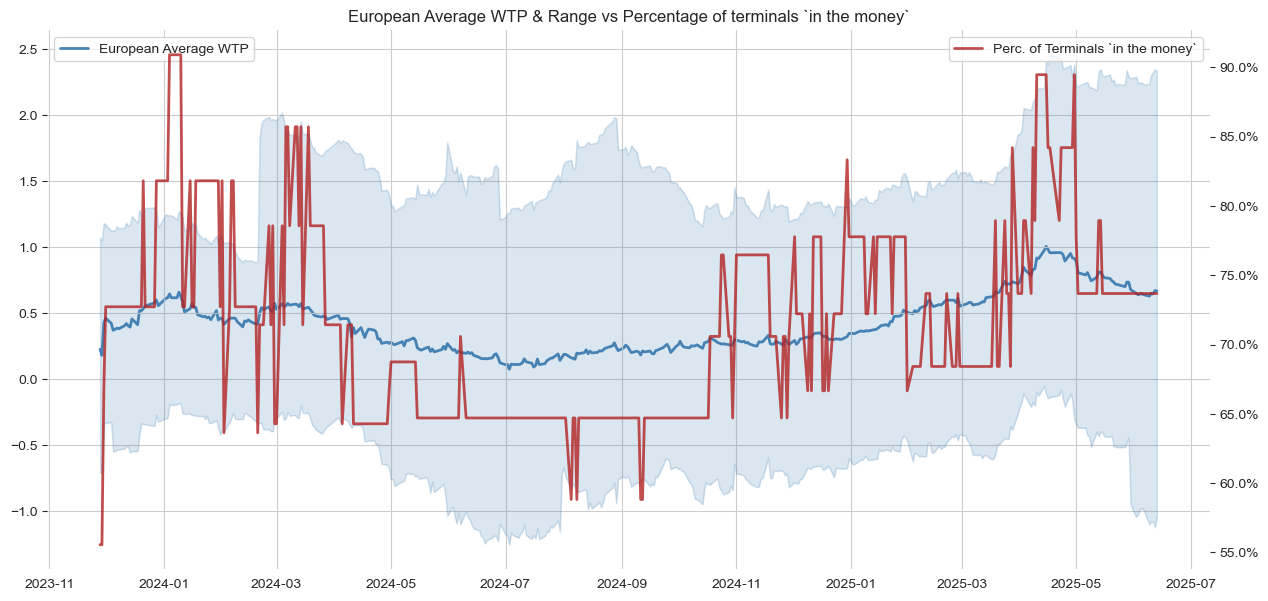

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

sns.set_style('whitegrid')

fig2, ax2 = plt.subplots(figsize=(15, 7))

ax2.plot(wtp_df['Release Date'], wtp_df['Ave'], color='steelblue', linewidth=2.0, zorder=0, label='European Average WTP')
ax2.plot(wtp_df['Release Date'], wtp_df['Min'], color='steelblue', linewidth=1.0, alpha=0.06)
ax2.plot(wtp_df['Release Date'], wtp_df['Max'], color='steelblue', linewidth=1.0, alpha=0.06)
ax2.fill_between(wtp_df['Release Date'], wtp_df['Min'], wtp_df['Max'], color='steelblue', alpha=0.2)

ax22 = ax2.twinx()

ax22.plot(wtp_df['Release Date'], wtp_df['Fraction']*100, color='firebrick', linewidth=2.0, alpha=0.8, zorder=1, label='Perc. of Terminals `in the money`')
ax22.yaxis.set_major_formatter(mtick.PercentFormatter())
ax22.grid(False)

plt.title('European Average WTP & Range vs Percentage of terminals `in the money`')
ax2.legend(loc=2)
ax22.legend(loc=0)


sns.despine(left=True, bottom=True)